## Analyzing the importance of features in a Neural Network

How do we know if a feature is important for our prediction? And at which values does its importance for the end result increase?
The idea is to let the model do a lot of predictions and see how they change when changing the input features.
This code snippet will demonstrate the process:

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

Side Info: <br />
Regulizers are used to keep the values of the neurons low. This is done so that the network doesnt get too dependend on
single neurons. The regulizers basically sum up the values of each layer (and square them) and add them to the overall loss.

In [9]:
# define data
X = [[0, 9, 7, 6, 3], [7, 8, 1, 3, 2], [2, 3, 2, 2, 3], [3, 4, 10, 7, 1], [4, 8, 4, 3, 0], [3, 2, 4, 1, 7], [5, 0, 3, 8, 9], [9, 4, 0, 4, 3], [3, 4, 0, 2, 4], [3, 3, 1, 2, 4],
[0, 4, 8, 4, 3], [2, 0, 1, 9, 2], [2, 7, 2, 0, 8], [1, 4, 2, 10, 1], [1, 6, 1, 2, 9], [8, 4, 9, 4, 3], [9, 2, 5, 9, 2], [2, 7, 2, 5, 0], [7, 6, 2, 10, 1], [1, 9, 0, 6, 0]]
y = [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]

features = len(X[0])

# split data into test and validation
splt = 0.75

X_train = X[:int(splt*len(X))]
y_train = y[:int(splt*len(y))]

X_val = X[int(splt*len(X)):]
y_val = y[int(splt*len(y)):]

This snippet will make categorial data for the model to train on. A sample of the training data will be a list of 5 numbers, as you can see if the 4th number is bigger than 5, the label will be 1. The network should be able to detect that pattern. The goal later on will be to find out that the other columns are therefore irrelevant by analyzing the importance of each of the 5 features (numbers).

In [10]:
# define model structure
model = keras.Sequential([
keras.layers.Dense(64, activation = "relu", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4)),
keras.layers.Dropout(.1),
keras.layers.Dense(1, activation = "sigmoid")
])

# define optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

# train the model
model.compile(optimizer = opt, loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])
model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val))

Epoch 1/100
1/1 [==============================] - 0s 499ms/step - loss: 1.4228 - accuracy: 0.3333 - val_loss: 0.6679 - val_accuracy: 0.8000
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 1.5792 - accuracy: 0.3333 - val_loss: 0.6554 - val_accuracy: 0.8000
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 1.3985 - accuracy: 0.3333 - val_loss: 0.6448 - val_accuracy: 0.8000
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 1.3896 - accuracy: 0.3333 - val_loss: 0.6369 - val_accuracy: 0.8000
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 1.3649 - accuracy: 0.4000 - val_loss: 0.6320 - val_accuracy: 0.8000
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 1.3256 - accuracy: 0.3333 - val_loss: 0.6297 - val_accuracy: 0.8000
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 1.1289 - accuracy: 0.4000 - val_loss: 0.6300 - val_accuracy: 0.8000
Epoch 8/100
1/1 [==

In [11]:
# evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val)
print(test_loss, test_acc)

1/1 [==============================] - 0s 27ms/step - loss: 0.4603 - accuracy: 0.8000
0.46025171875953674 0.800000011920929


In [12]:
# predict on new data
prediction = model.predict([[0, 1, 3, 9, 5]])
print(prediction)

[[0.9684326]]


What were doing next is basically making predictions for different input data with the model we just trained. Were going to look at one input and manipulate each of the features values seperatly and then predict the output again. The error is then calculated between the output and the real output which will tell us about how impactfull that change of value of that specific feature was. Were going to do that for all of the input data.

In [13]:
error_values = []
mse = tf.keras.losses.MeanSquaredError()

# for each feature
for c in range(features):

    error_temp, value_temp = [], []

    # for each data list
    for counter1, a in enumerate(X):

        # remove currently inspecting element
        X_temp = X.copy()
        del X_temp[counter1]

        for counter2, b in enumerate(X_temp):

            # change value for feature
            a[c] = b[c]

            # make prediciton with changed data
            pred = model.predict([a])

            # calculate error
            error = mse(y[counter1], pred).numpy()

            # append to lists
            error_temp.append(error)
            value_temp.append(b[c])

    error_values.append([error_temp, value_temp, c])

#print(error_values)

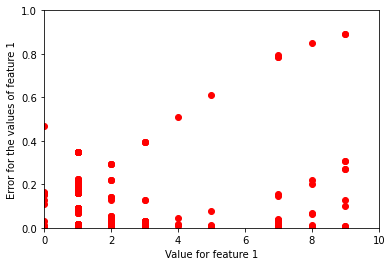

Total Error: 36.04023447003419


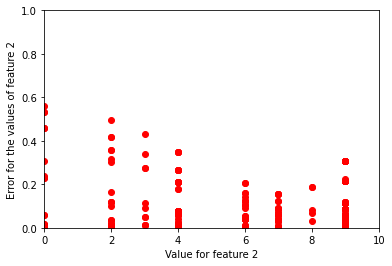

Total Error: 34.94687994214473


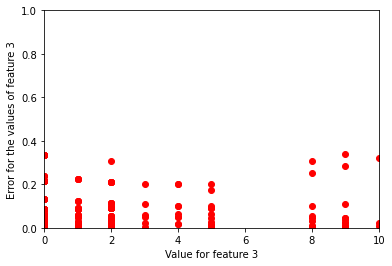

Total Error: 28.920737188818748


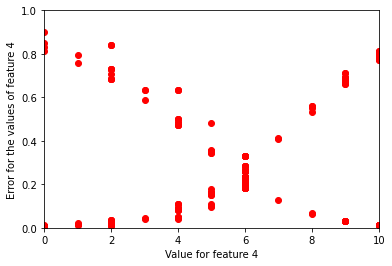

Total Error: 109.48414365737699


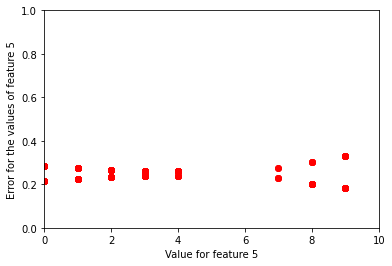

Total Error: 95.08327195048332


In [14]:
for i in range(features):
    plt.plot(error_values[i][1], error_values[i][0], 'ro')
    plt.axis([0, 10, 0, 1])
    plt.xlabel(f'Value for feature {i+1}')
    plt.ylabel(f'Error for the values of feature {i+1}')
    plt.show()

    sum = 0
    for x in error_values[i][0]: sum += x
    print(f'Total Error: {sum}')

As you can see, the total error of Feature 4 is the greatest, which means it probably has the most impact on the result of the networks prediction. The graph also shows that.

